In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import heapq as hq
%matplotlib inline

In [2]:
from libs.utils import list2matrix
from libs.plotNetwork import plotNetworkClusters
from libs.page_rank import localPageRank

In [3]:
df = pd.read_csv("http://cs.joensuu.fi/sipu/datasets/Aggregation.txt", sep='\t', names=["x", "y", "cluster"])
df.head()

,x,y,cluster
0,15.55,28.65,2
1,14.90,27.55,2
2,14.45,28.35,2
3,14.15,28.80,2
4,13.75,28.05,2


In [4]:
np.random.seed(0)

In [5]:
clusters = np.array(df.cluster)
centroids = []
for cluster in np.unique(clusters):
    nodes = np.arange(df.shape[0])[clusters==cluster]
    centroids.append(np.random.choice(nodes, 1)[0])
print(centroids)

[753, 47, 541, 455, 757, 682, 179]


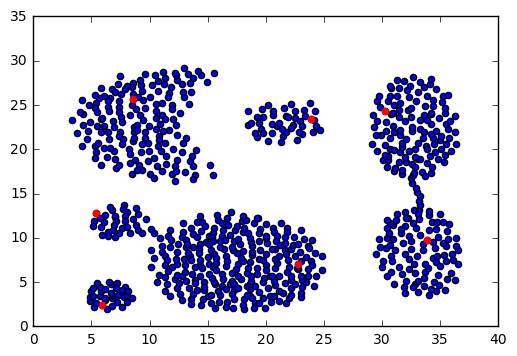

In [6]:
plt.figure()
plt.scatter(df.x, df.y)
plt.scatter(df.x.iloc[centroids], df.y.iloc[centroids], color='r')
plt.show()

In [7]:
positions = np.array(df[["x", "y"]])
positions[:10]

array([[ 15.55,  28.65],
       [ 14.9 ,  27.55],
       [ 14.45,  28.35],
       [ 14.15,  28.8 ],
       [ 13.75,  28.05],
       [ 13.35,  28.45],
       [ 13.  ,  29.15],
       [ 13.45,  27.5 ],
       [ 13.6 ,  26.5 ],
       [ 12.8 ,  27.35]])

In [8]:
def generate_edges(positions, radius=1):
     
    # initialize the edgelist
    N = positions.shape[0]
    idxs = np.arange(N)
    A = [[]]*N
    
    for i in range(N):
        point = positions[i,:]
        dists = np.linalg.norm(point-positions, axis=1)
        neighs = idxs[np.logical_and(dists<=radius, idxs!=i)]
        A[i] = []
        for j, neigh in enumerate(neighs):
            A[i].append((neigh, dists[idxs!=i][j]))
            
    return A

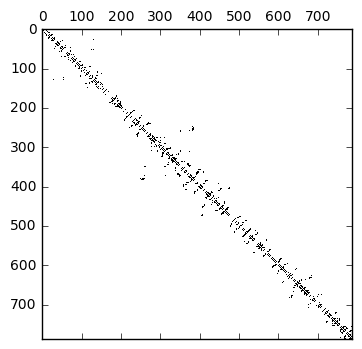

In [9]:
A = generate_edges(positions, 1.5)
A_mat = list2matrix(A)
plt.figure()
plt.spy(A_mat)
plt.show()

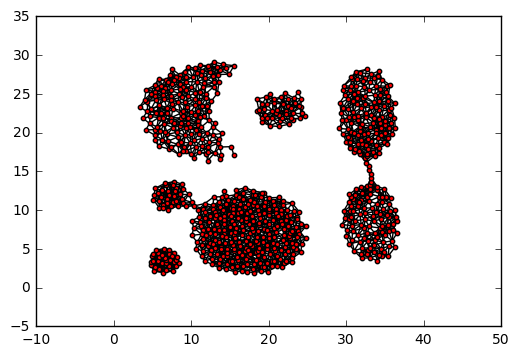

In [10]:
g = nx.Graph(A_mat)
plt.figure()
nx.draw_networkx(g, pos=positions, node_size=10, with_labels=False)
plt.show()

In [1]:
# the function computes the network clustering
def cluster(L_norm, centroids, alpha, A, plot_end=True, plot_steps=False, pos=None, node_size=10, draw_edges=False):  
    # initialize the output vector with the clusters
    clusters = - np.ones(len(L_norm))
    
    if plot_steps:
        colors = None
    
    # initialize the heap queues related to the clusters
    queues = []
    
    # insert centroids in the queues, e.g. (expansions, (node, rank))
    for i in range(centroids.size):
        queue = []
        hq.heappush(queue, (0, (centroids[i], 1)))
        queues.append(queue)
        
        # set the centroid cluster
        clusters[centroids[i]] = centroids[i]
    
    # iterate until all the nodes are assigned to the clusters   
    exit_ext = False
    while not exit_ext:
        #
        cumulative_length = 0
        for queue in queues:
            # assign the new expansions
            for i, node in enumerate(queue):
                # ensure at least one expansion per node
                expansions = max(1, np.round(alpha*node[1][1])) # TODO: eventually change the round function
                
                # modify the queue element with the new expansions
                queue[i] = (
                    - expansions,
                    (node[1][0], node[1][1])
                )
            
            # restore the queue
            hq.heapify(queue)
            
            #print(queue)
        
            # expand the cluster boundary toward the high ranked nodes
            exit_int = False
            while (not exit_int) and len(queue)>0: # TODO: check correctness
                # pop a node that should be expanded 
                node = hq.heappop(queue)
                #print("popped")
                
                # check the termination condition
                expansions_opp = node[0]
                if expansions_opp==0:
                    # no more nodes to expand
                    exit_int = True
                else:
                    #print("else")
                    # reduce the remained number of expansions
                    expansions_opp += 1
                    
                    # TODO: exploit the edgelist to enhance efficiency and ensure correctness
                    # expand the neighbourhood and assign the new expansions
                    #print("where", np.where(L[node[1][0],:]>0)[0])
                    for edge in L_norm[node[1][0]]:
                        #print(neighbour)
                        neighbour = edge[0]
                        # assign the node to the cluster
                        if clusters[neighbour]<0:
                            #print("assigned")
                            clusters[neighbour] = clusters[node[1][0]]
                            
                            # add the node to the queue
                            rank = edge[1]
                            hq.heappush(
                                queue,
                                (
                                    np.round(expansions_opp*rank), # TODO: eventually change the round function
                                    (neighbour, rank)
                                )
                            )
                            
            # TODO: check
            cumulative_length += len(queue) 
        
        exit_ext = cumulative_length==0
    
        # test plot <-> CLUSTERS SHOULD BE A LIST!
        if plot_steps:
            pos, colors = plotNetworkClusters(A, list(clusters.astype(int)), node_size, draw_edges=draw_edges, pos=pos, colors=colors)
        
    if plot_end and not plot_steps:
        plotNetworkClusters(A, list(clusters.astype(int)), node_size, draw_edges=draw_edges)
    
    # return the vector with the clusters
    return clusters

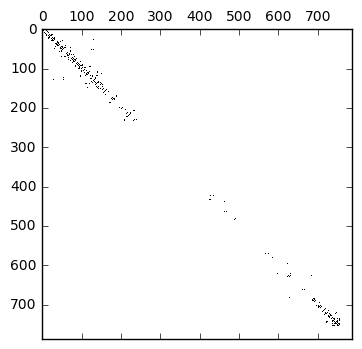

In [17]:
# generate the L matrix
L = localPageRank(A, c=0.85, return_only_neighbours=True)
L_mat = list2matrix(L)
plt.figure()
plt.spy(L_mat)
plt.show()

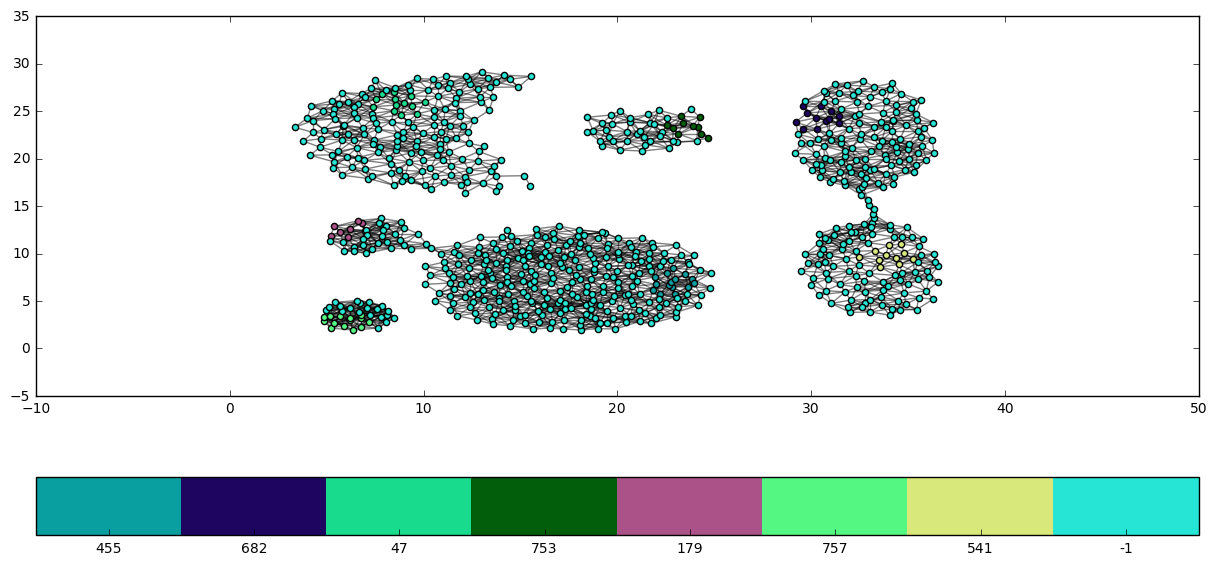

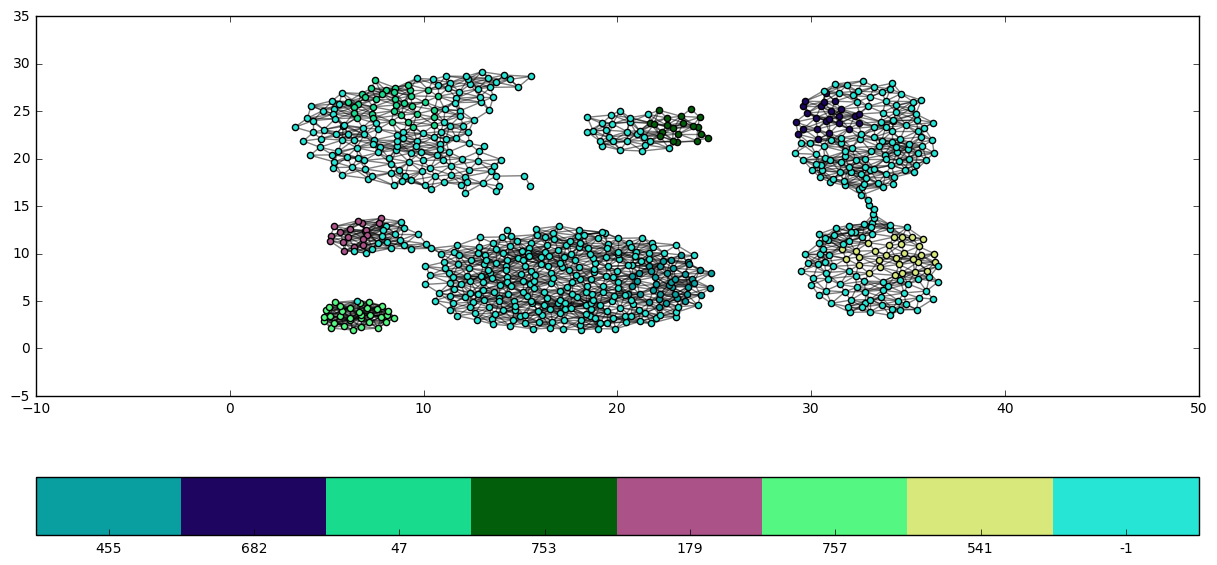

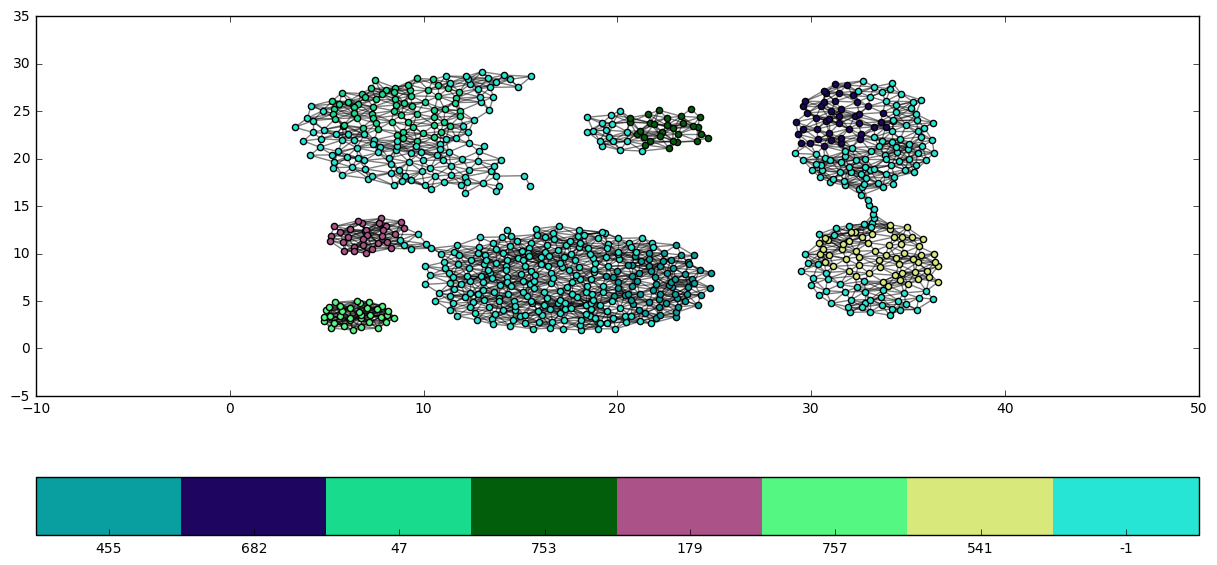

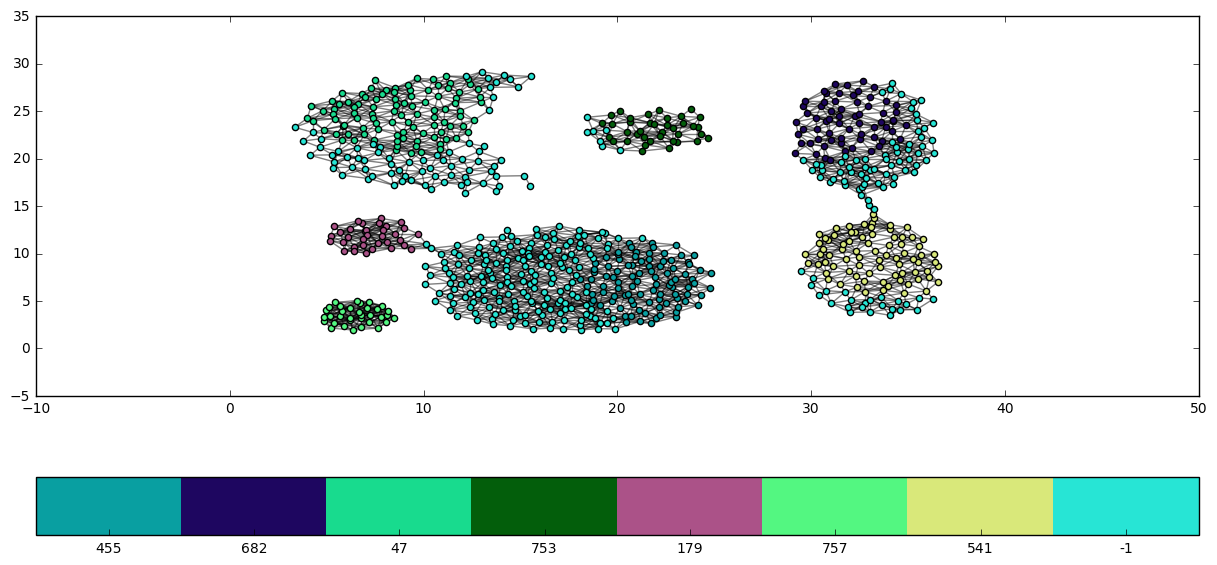

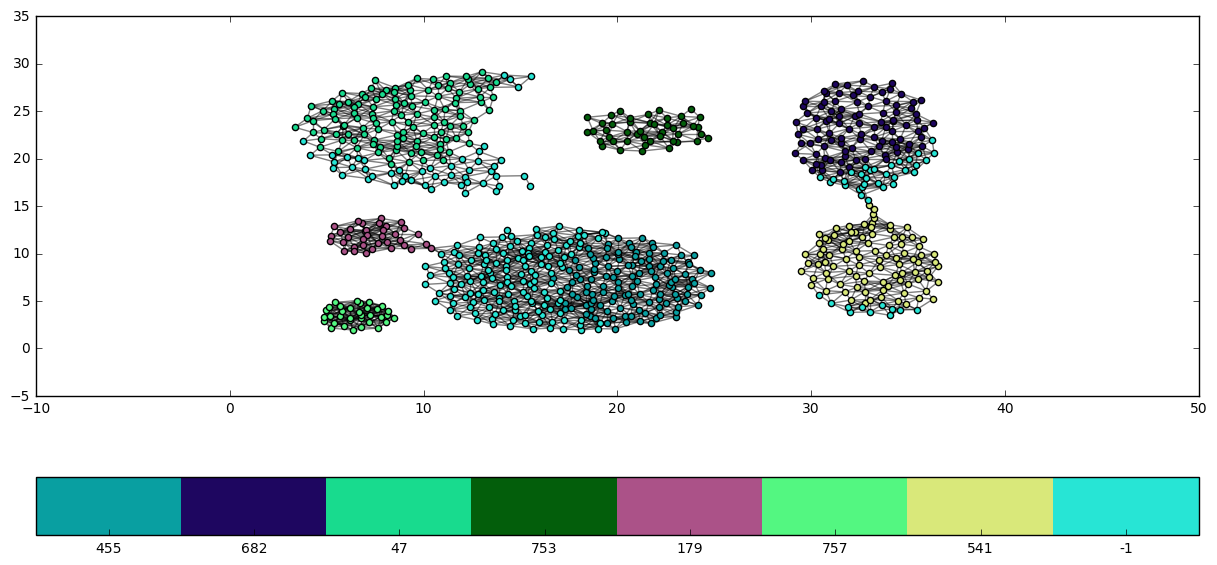

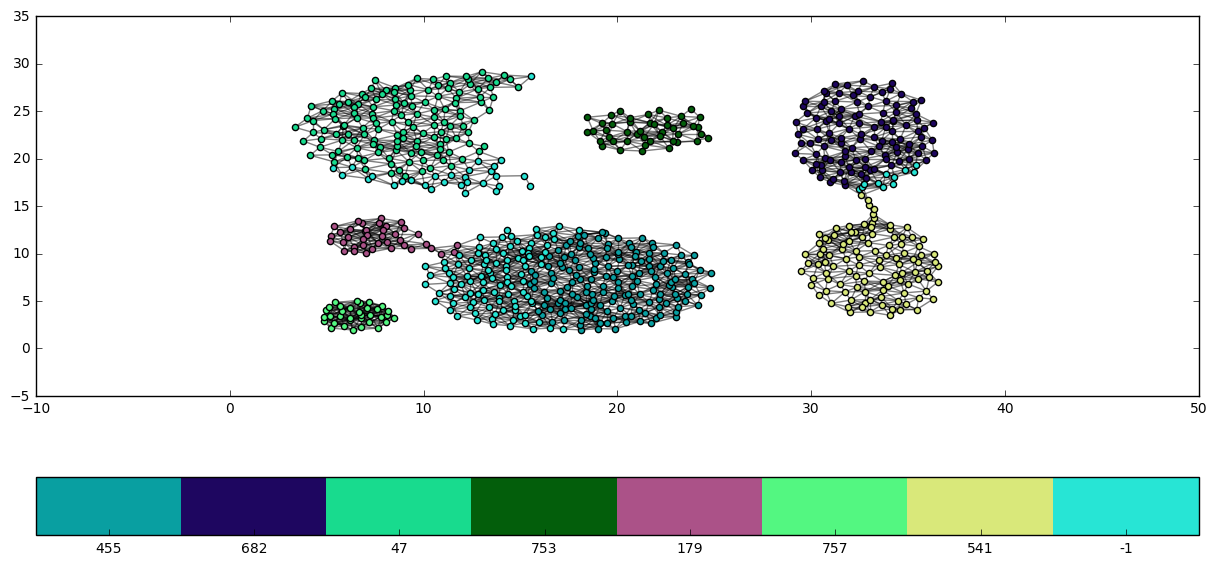

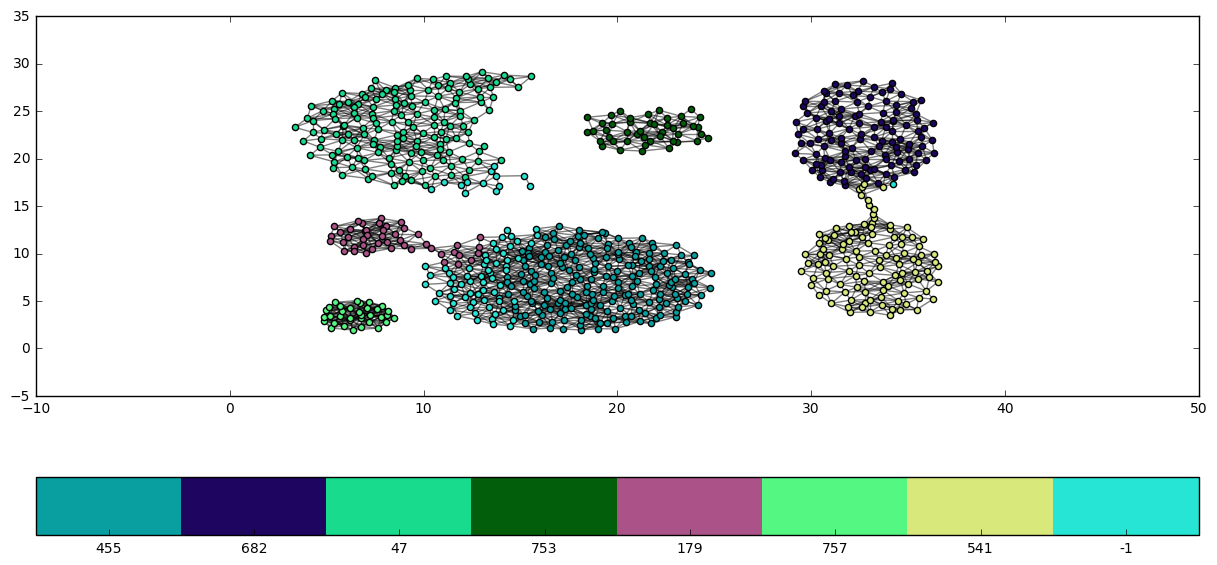

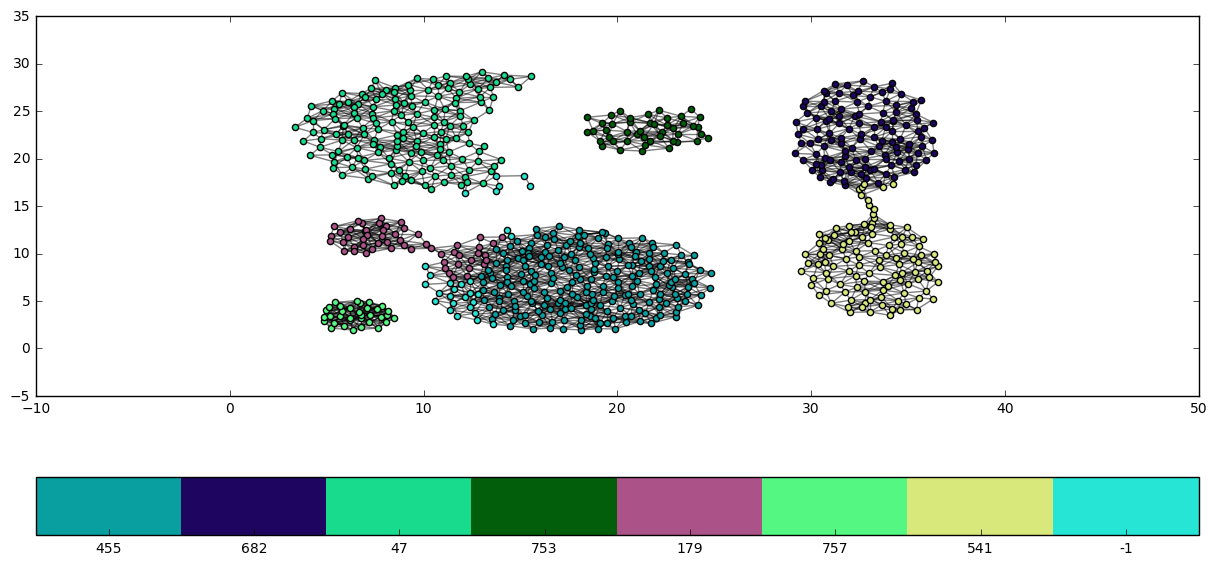

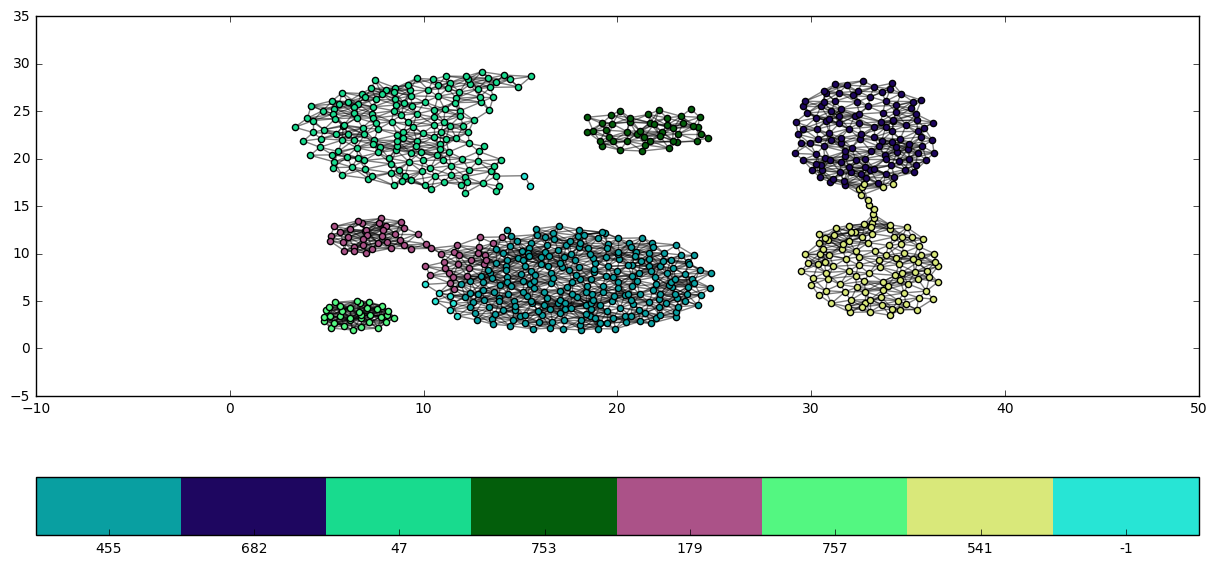

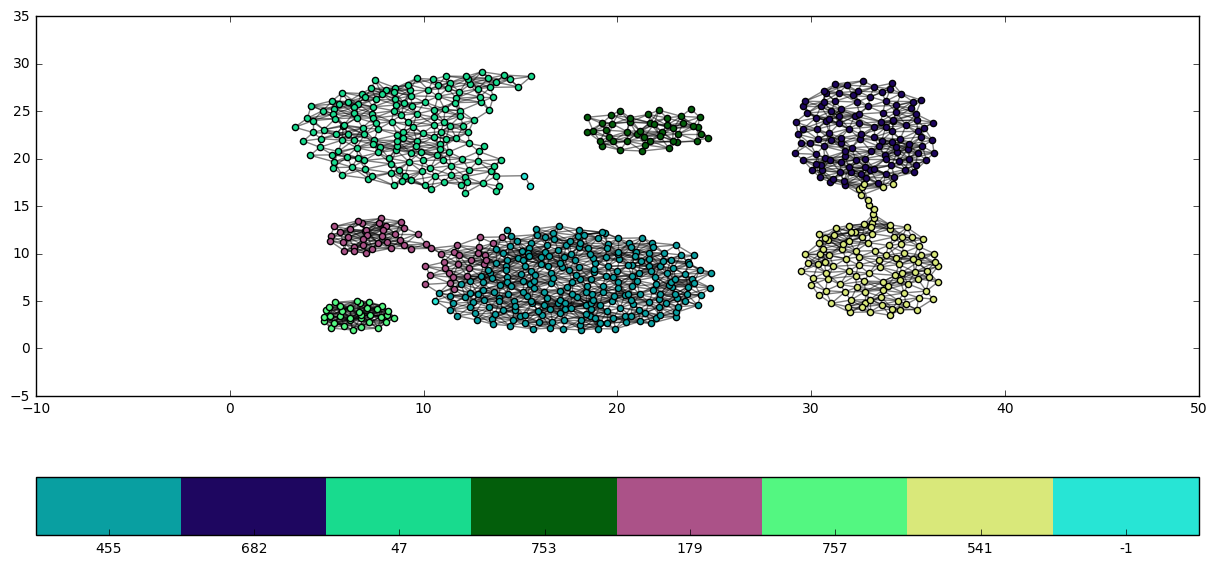

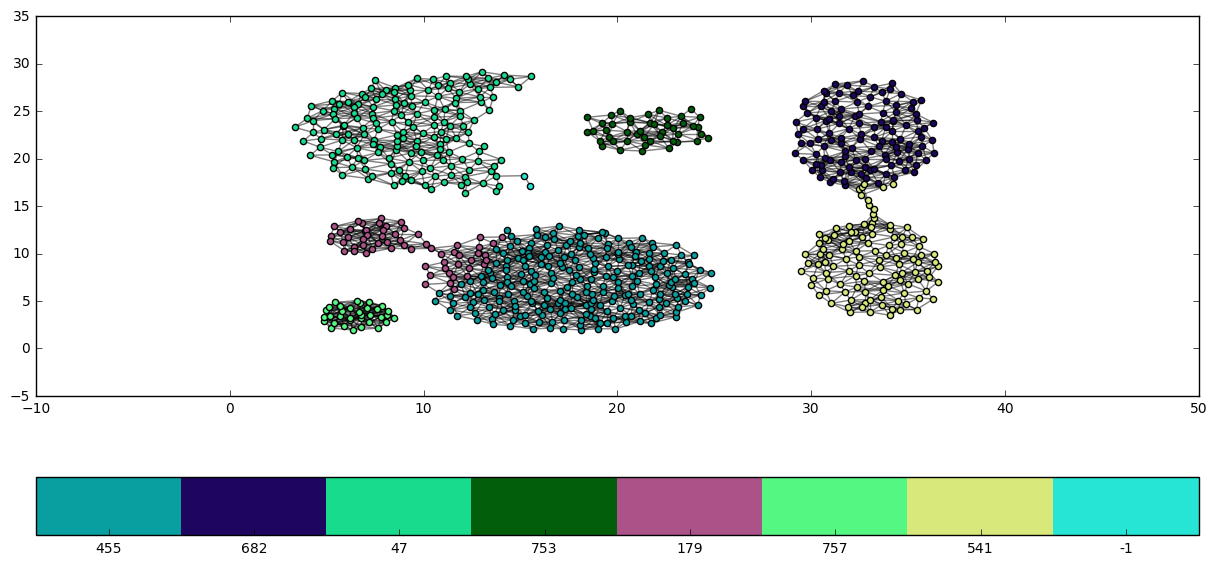

array([  47.,   47.,   47.,   47.,   47.,   47.,   47.,   47.,   47.,
         47.,   47.,   47.,   47.,   47.,   47.,   47.,   47.,   47.,
         47.,   47.,   47.,   47.,   47.,   47.,   47.,   47.,   47.,
         47.,   47.,   47.,   47.,   47.,   47.,   47.,   47.,   47.,
         47.,   47.,   47.,   47.,   47.,   47.,   47.,   47.,   47.,
         47.,   47.,   47.,   47.,   47.,   47.,   47.,   47.,   47.,
         47.,   47.,   47.,   47.,   47.,   47.,   47.,   47.,   47.,
         47.,   47.,   47.,   47.,   47.,   47.,   47.,   47.,   47.,
         47.,   47.,   47.,   47.,   47.,   47.,   47.,   47.,   47.,
         47.,   47.,   47.,   47.,   47.,   47.,   47.,   47.,   47.,
         47.,   47.,   47.,   47.,   47.,   47.,   47.,   47.,   47.,
         47.,   47.,   47.,   47.,   47.,   47.,   47.,   47.,   47.,
         47.,   47.,   47.,   47.,   47.,   47.,   47.,   47.,   47.,
         47.,   47.,   47.,   47.,   47.,   47.,   47.,   47.,   47.,
         47.,   47.,

In [21]:
cluster(L, np.array(centroids), 2, A_mat, plot_steps=True, pos=positions, node_size=20, draw_edges=True)